# Decomposition of all velocity components

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import pandas as pd
import copy
import scipy
from scipy import signal
import glob
from pydmd.costs import COSTS
from pydmd.mrcosts import mrCOSTS

# OS interaction
import os
import sys

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import string

# PyDMD can generate way too many warnings
import warnings

warnings.filterwarnings("ignore")

## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = "paper"
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    "#4477AA",
    "#CCBB44",
    "#EE6677",
    "#228833",
    "#66CCEE",
    "#AA3377",
    "#BBBBBB",
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

alphabet = string.ascii_lowercase

# Data

Re-running this cell more than once will likely break the logic we are using here for setting up the directory structure.

In [3]:
dir_notebook = os.getcwd()
dir_data = os.path.join(dir_notebook, "data")
dir_print = os.path.join(dir_notebook, "figures/SI figures")
dir_results = os.path.join(dir_notebook, "mrCOSTS fit")

## Define common variables and lists

In [4]:
components = ["w", "u", "v"]
domain_list = ["1km", "500m", "250m", "125m", "lidar"]
domain_titles_dict = {
    "1km": "DX1000",
    "500m": "DX500",
    "250m": "DX250",
    "125m": "DX1215",
    "lidar": "lidar",
}

## Load model data

In [5]:
os.chdir(dir_data)
ds_data = {}
for domain in domain_list:
    ds_data[domain] = xr.open_dataset(f"{domain}.publication-version.nc").load()


ts = ds_data["lidar"].time
ts = ts - ts.isel(time=0)
ts = (ts / 1e9).values.astype(float)
# Time step in seconds
dt = 80

# Load mrCOSTS fits

Please read the README. You must first generate your mrCOSTS fits. The model fits are not included as they are much larger than the data.

In [6]:
os.chdir(dir_results)
strategy = "conj-pair"
mrc_dict = {}

for domain in domain_list:
    fnames = "*".join(["", domain, strategy, ".nc"])
    file_list = glob.glob(fnames)
    mrc = mrCOSTS()
    mrc.from_netcdf(file_list)
    mrc_dict[domain] = mrc

# Global scale separation

In [7]:
# Note I made some subjective decisions by choosing the largest
# number of justifiable bands in order to best separate the
# bands.
n_optimal_dict = {
    "1km": 20,
    "500m": 15,
    "250m": 11,
    "125m": 23,
    "lidar": 18,
}

In [8]:
for ndomain, domain in enumerate(domain_list):

    mrc = mrc_dict[domain]

    cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
        n_optimal_dict[domain], transform_method="log10"
    )

# Reconstruction

In [9]:
def to_period(cluster_centers):
    cl_periods = (2 * np.pi) / 10**cluster_centers
    return cl_periods

In [10]:
xr_global_dict = {}
xr_sep_dict = {}
xr_background_dict = {}
xr_global_combined = {}
for domain in domain_list:
    mrc = mrc_dict[domain]
    cluster_center_periods = to_period(mrc.cluster_centroids)

    xr_sep = mrc.global_scale_reconstruction()
    xr_background = mrc.get_background()
    xr_global = xr_sep.sum(axis=(0, 1)) + xr_background

    xr_sep_w, xr_sep_u, xr_sep_v = np.split(xr_sep, indices_or_sections=3, axis=2)
    xr_global_w, xr_global_u, xr_global_v = np.split(
        xr_global, indices_or_sections=3, axis=0
    )

    # Add any G_p with scale larger than the maximum window size to the background.
    largest_resolvable = np.array(mrc.window_length_array).max() * 80
    add_to_bgd_ind = cluster_center_periods > largest_resolvable
    if any(add_to_bgd_ind):
        xr_sep_to_bgd = xr_sep[:, add_to_bgd_ind].sum(axis=(0, 1))
        # xr_sep_bgd_w, xr_sep_bgd_u, xr_sep_bgd_v = np.split(
        #     xr_sep_to_bgd, indices_or_sections=3, axis=0
        # )
        xr_background = xr_background + xr_sep_to_bgd
        xr_background_w, xr_background_u, xr_background_v = np.split(
            xr_background, indices_or_sections=3, axis=0
        )
    # Otherwise we handle the background mode as normal.
    else:
        xr_background_w, xr_background_u, xr_background_v = np.split(
            xr_background, indices_or_sections=3, axis=0
        )

    xr_global_dict[domain] = {
        "w": xr_global_w,
        "u": xr_global_u,
        "v": xr_global_v,
    }

    xr_sep_dict[domain] = {
        "w": xr_sep_w,
        "u": xr_sep_u,
        "v": xr_sep_v,
    }

    xr_background_dict[domain] = {
        "w": xr_background_w,
        "u": xr_background_u,
        "v": xr_background_v,
    }

    xr_global_combined[domain] = xr_global

In [11]:
xr_global_dict = {}
xr_sep_dict = {}
xr_background_dict = {}
xr_global_combined = {}
for domain in domain_list:
    mrc = mrc_dict[domain]
    cluster_center_periods = to_period(mrc.cluster_centroids)

    xr_sep = mrc.global_scale_reconstruction()
    xr_background = mrc.get_background()
    xr_global = xr_sep.sum(axis=(0, 1)) + xr_background

    xr_sep_w, xr_sep_u, xr_sep_v = np.split(xr_sep, indices_or_sections=3, axis=2)
    xr_background_w, xr_background_u, xr_background_v = np.split(
        xr_background, indices_or_sections=3, axis=0
    )
    xr_global_w, xr_global_u, xr_global_v = np.split(
        xr_global, indices_or_sections=3, axis=0
    )

    xr_global_dict[domain] = {
        "w": xr_global_w,
        "u": xr_global_u,
        "v": xr_global_v,
    }

    xr_sep_dict[domain] = {
        "w": xr_sep_w,
        "u": xr_sep_u,
        "v": xr_sep_v,
    }

    xr_background_dict[domain] = {
        "w": xr_background_w,
        "u": xr_background_u,
        "v": xr_background_v,
    }

    xr_global_combined[domain] = xr_global

## Evaluation

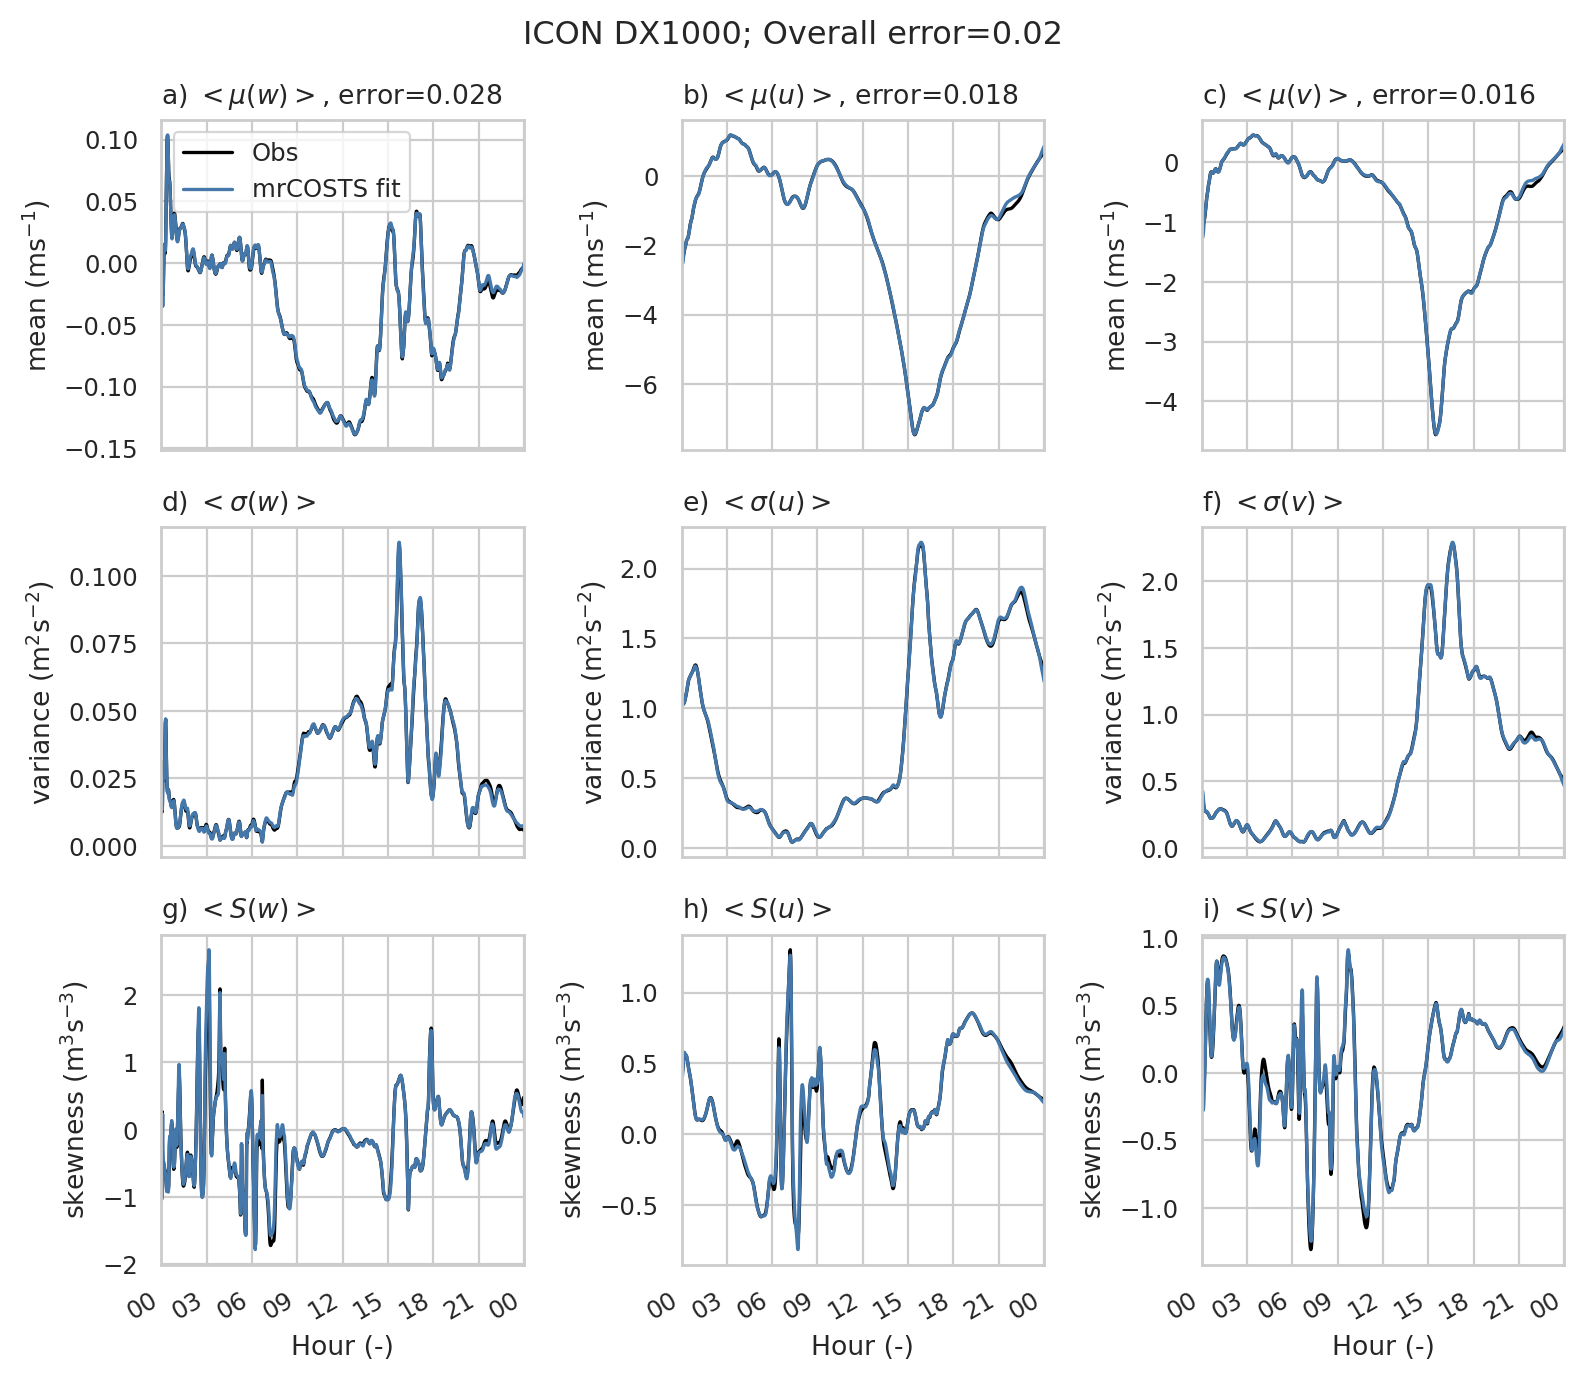

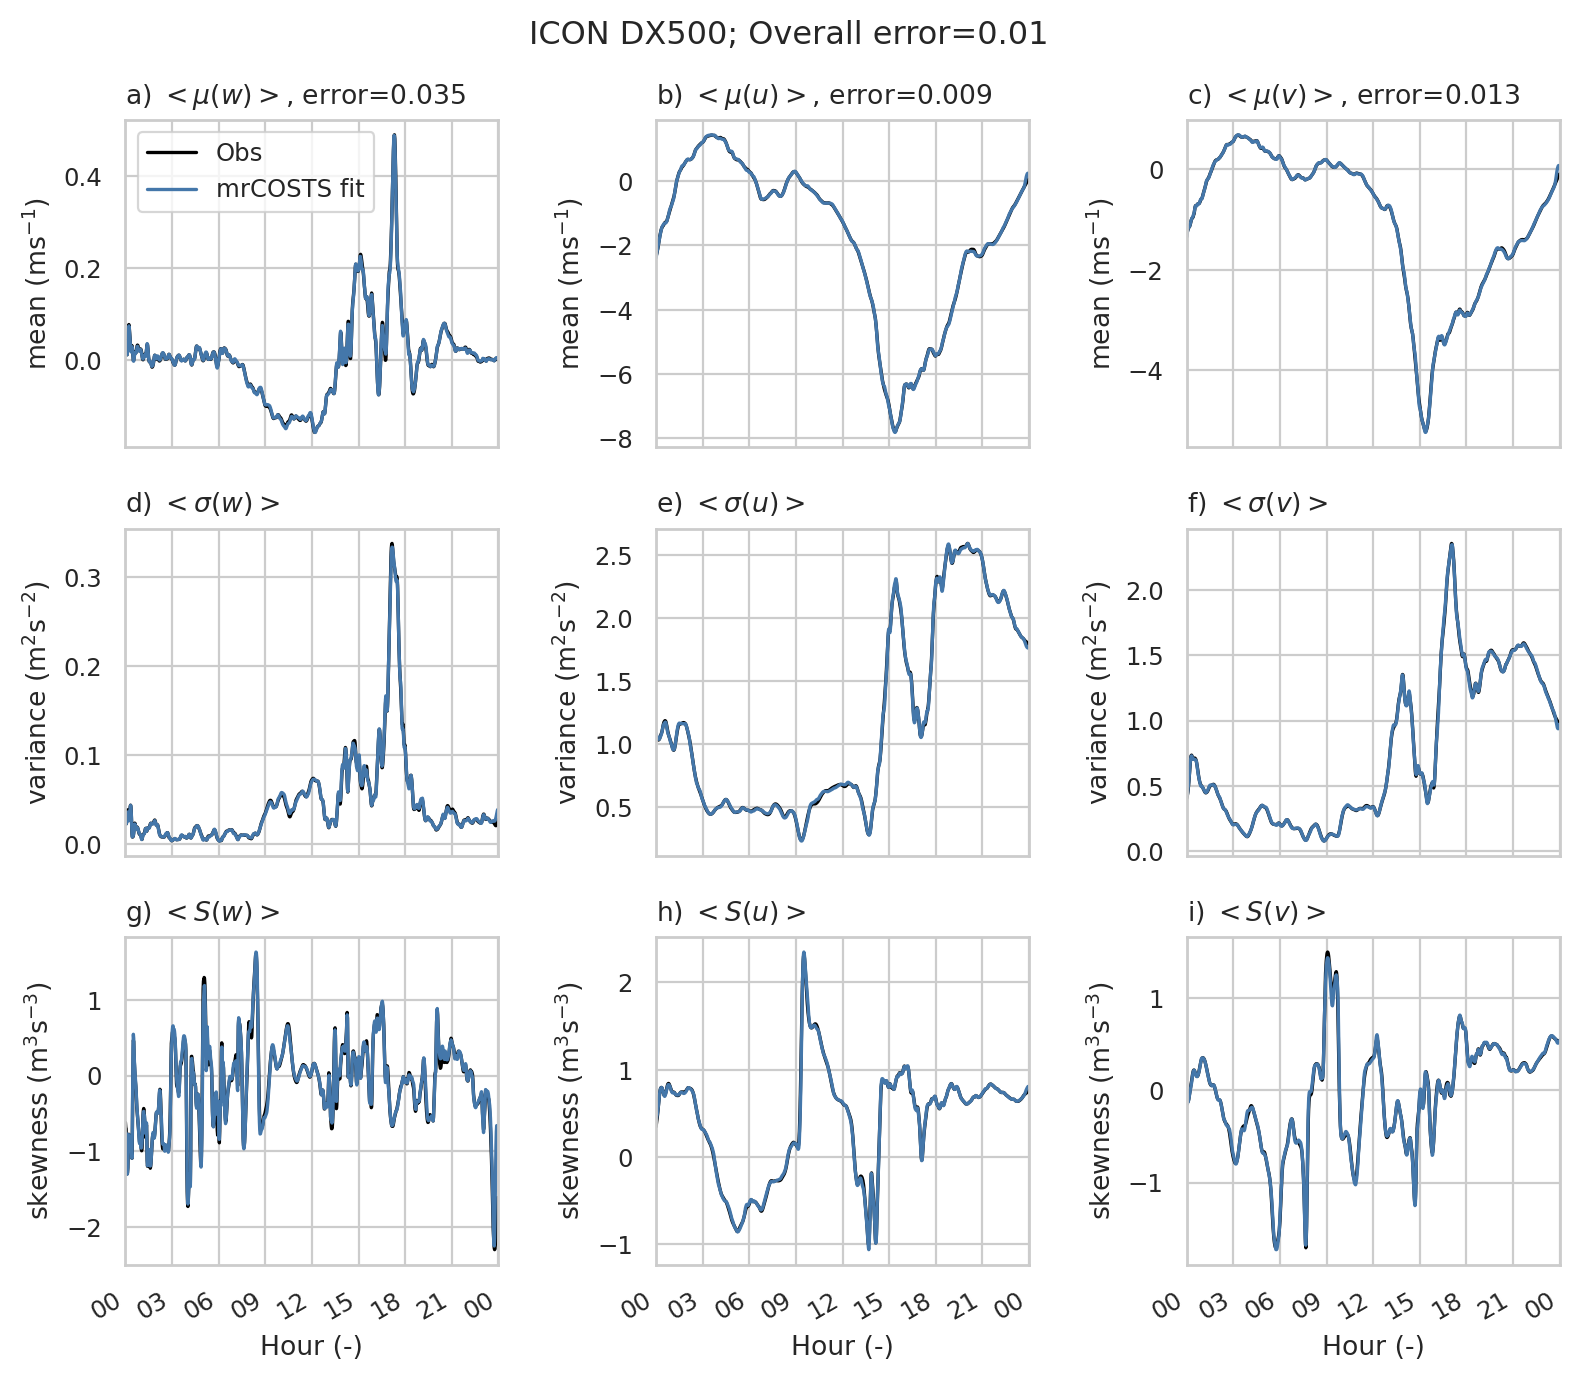

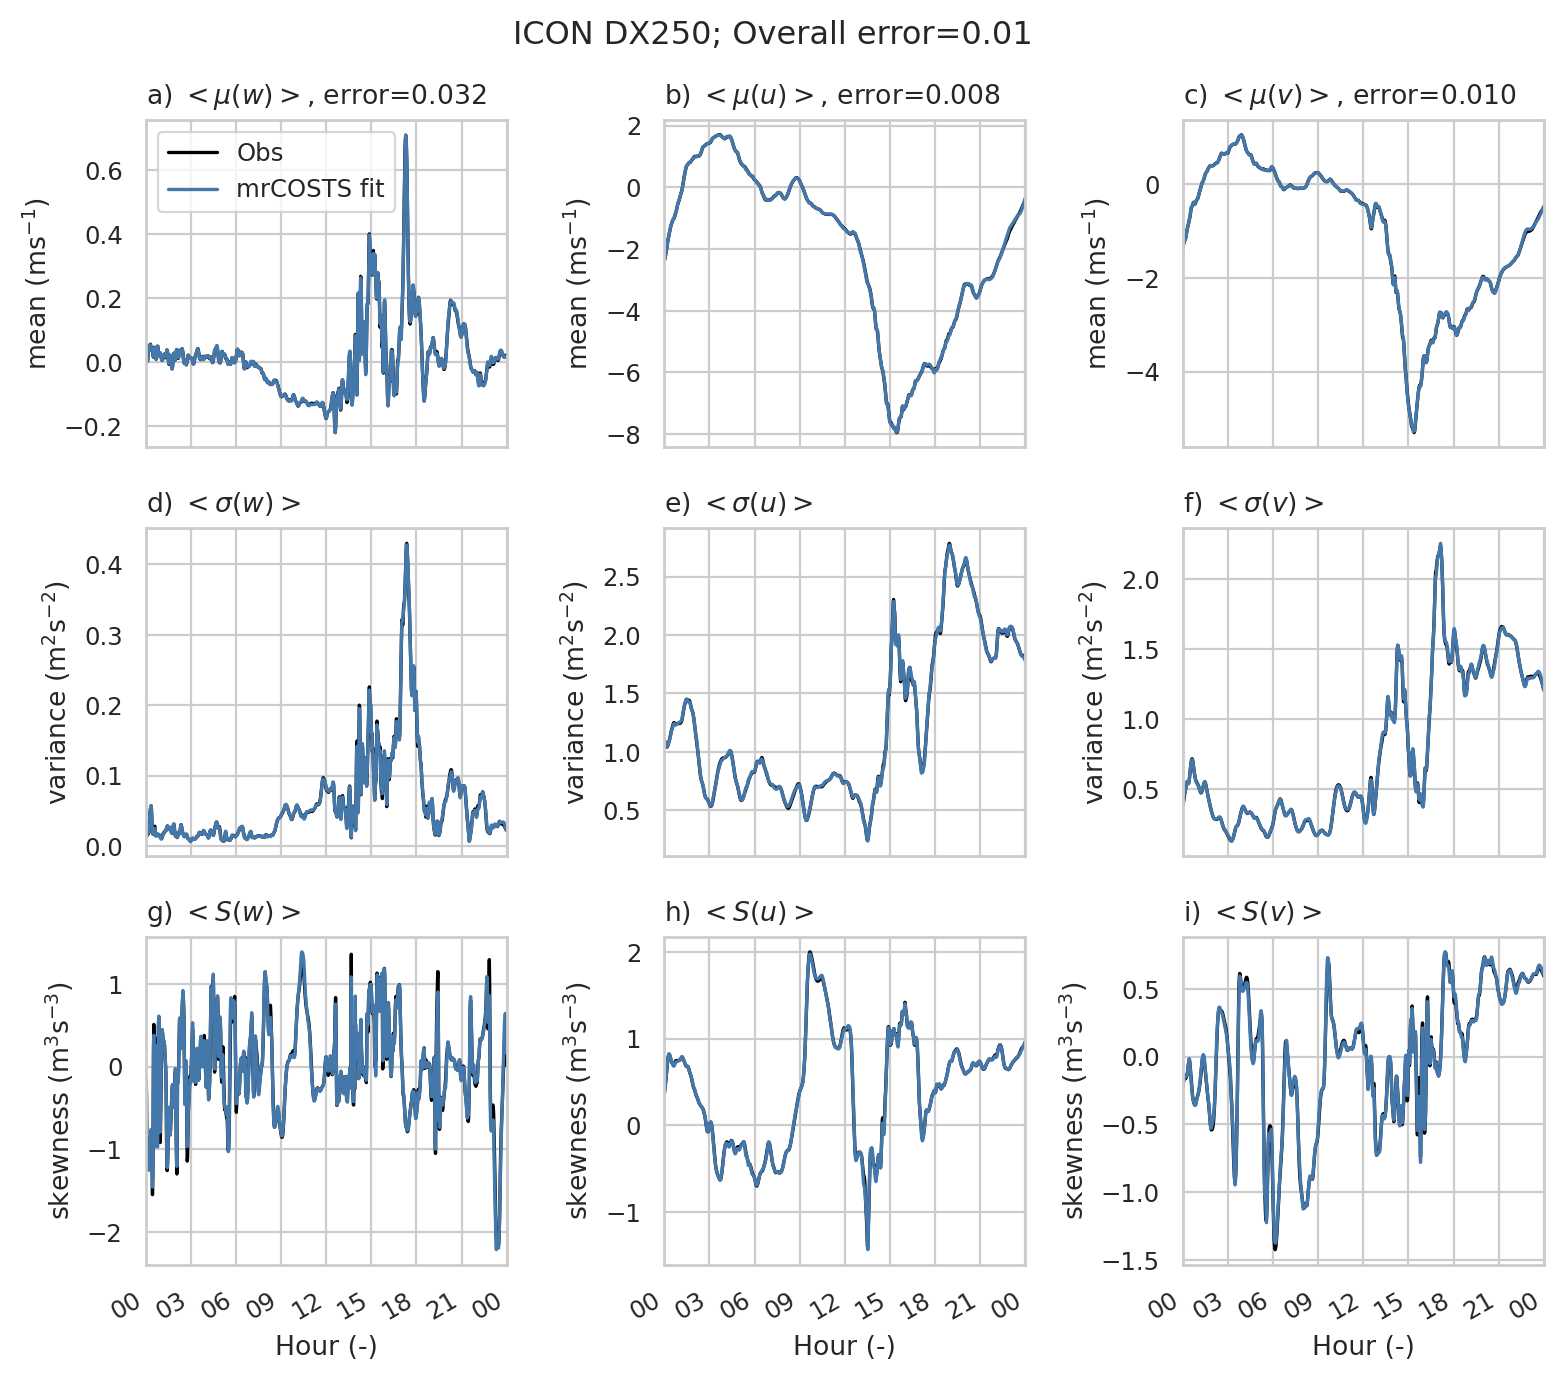

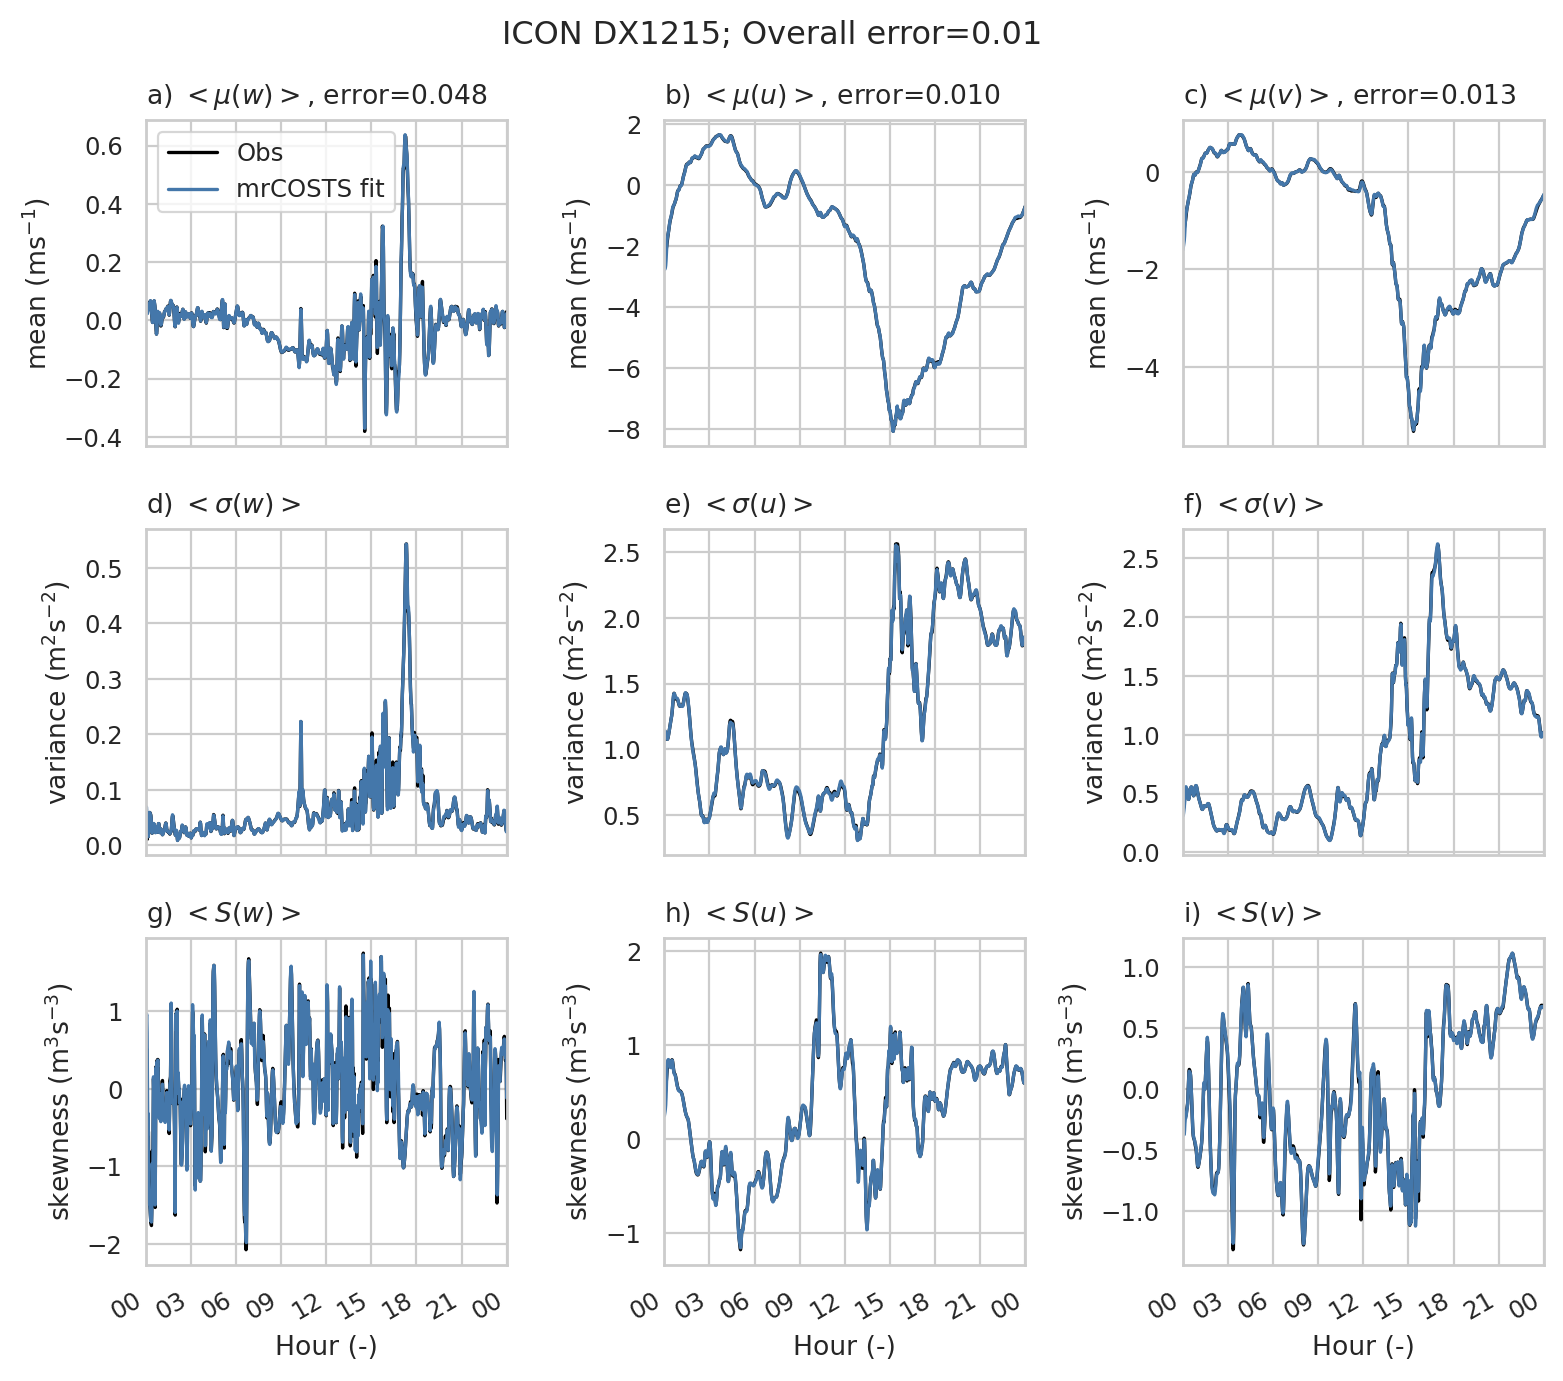

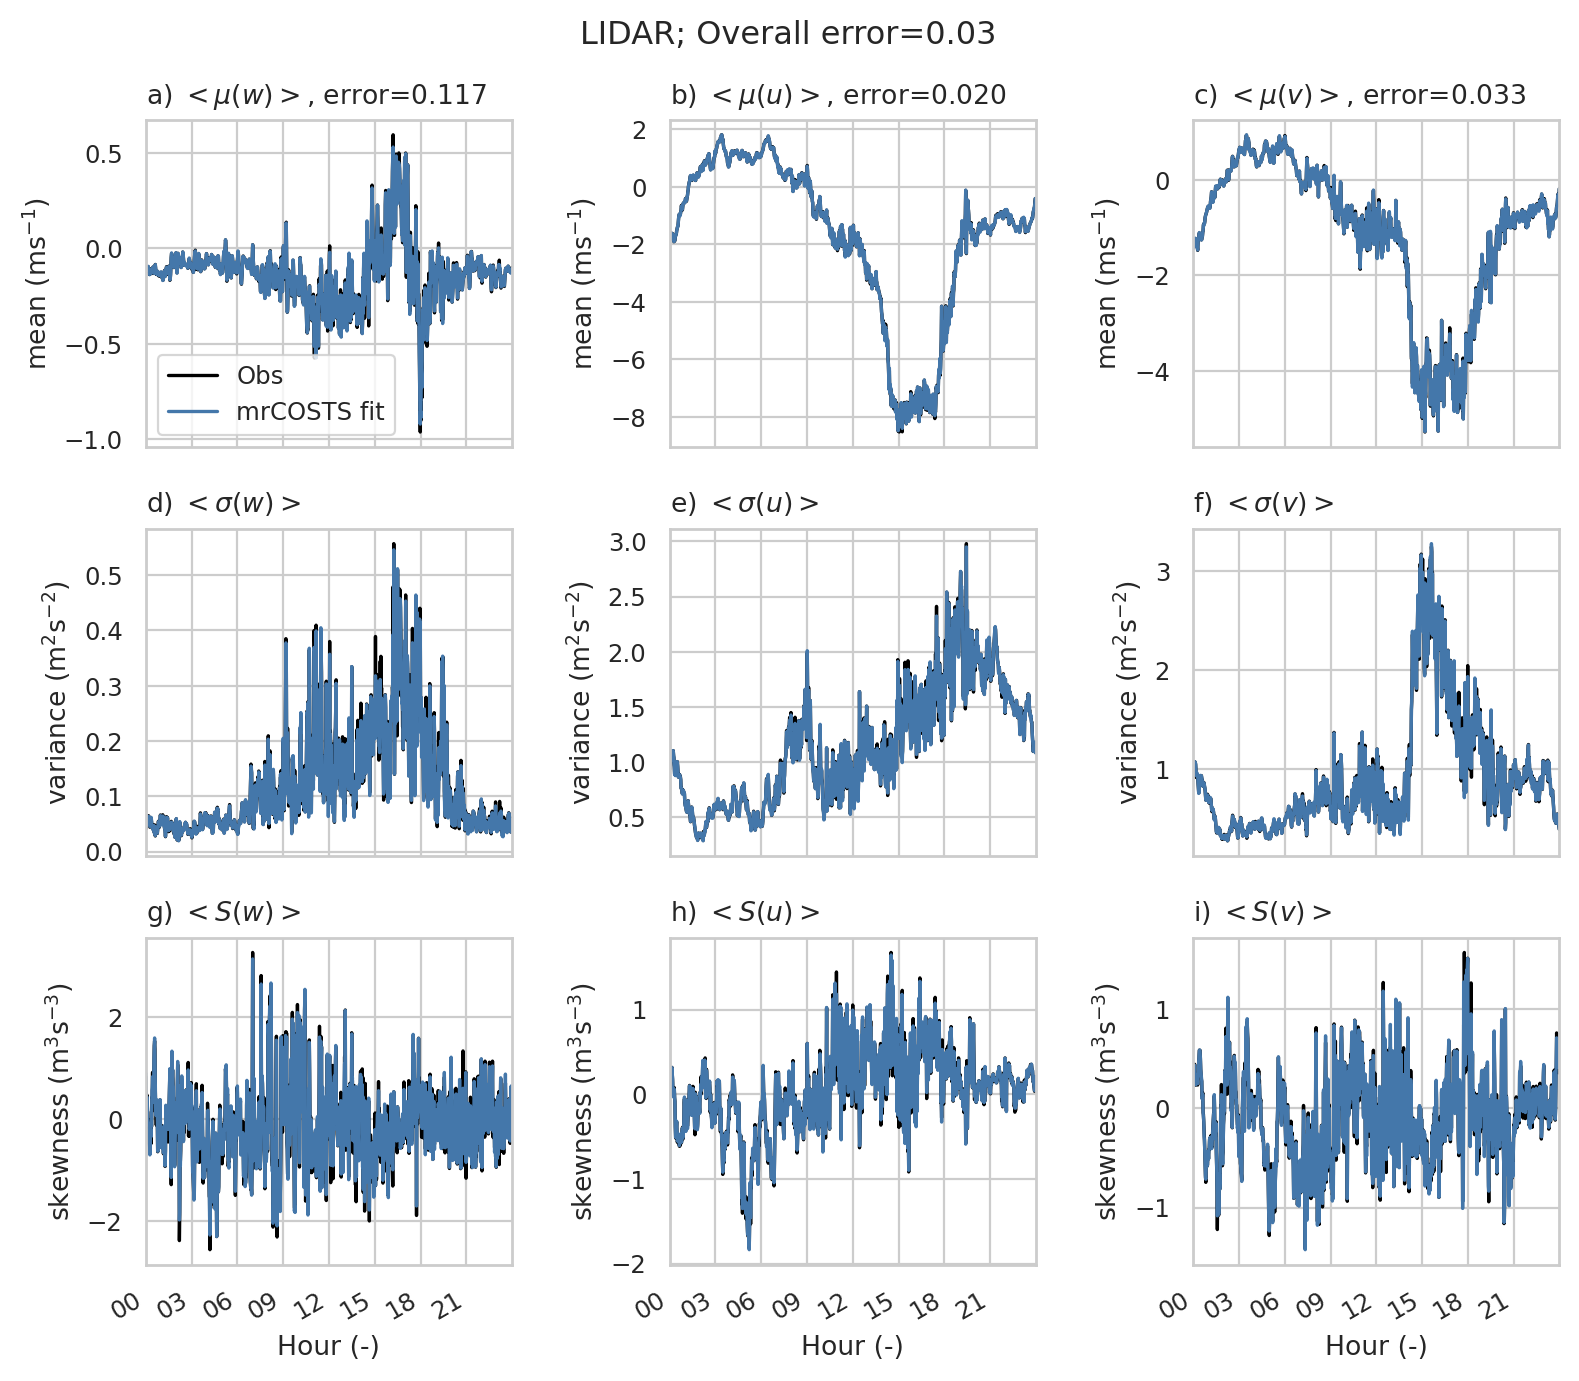

In [12]:
date_format = DateFormatter("%H")

for ndomain, domain in enumerate(domain_list):
    fig, axes = plt.subplots(3, 3, figsize=(8, 7), sharex=True)
    x = xr_global_combined[domain]
    ds_obs = ds_data[domain]
    data = np.concatenate(
        (ds_obs["w"].T.values, ds_obs["u"].T.values, ds_obs["v"].T.values)
    )
    overall_error = mrc.costs_array[0].relative_error(x, data)
    for ncomp, comp in enumerate(components):
        x = xr_global_dict[domain][comp]
        error = mrc.costs_array[0].relative_error(x.T, ds_obs[comp].values)
        ax = axes[0, ncomp]
        ax.plot(
            ds_obs.time, ds_obs[comp].mean(dim="height").values, color="k", label="Obs"
        )
        ax.plot(ds_obs.time, x.mean(axis=0), label=f"mrCOSTS fit")

        if ncomp == 0:
            ax.legend()
        ax.set_title(
            f"{alphabet[ncomp]}) $<\mu({comp})>$, error={error:.3f}", loc="left"
        )
        ax.set_ylabel("mean (ms$^{-1}$)")

        ax = axes[1, ncomp]
        ax.plot(
            ds_obs.time, ds_obs[comp].std(dim="height").values, color="k", label="Obs"
        )
        ax.plot(ds_obs.time, x.std(axis=0), label=f"mrCOSTS fit")

        ax.set_title(f"{alphabet[ncomp + 3]}) $<\sigma({comp})>$", loc="left")
        ax.set_ylabel("variance (m$^{2}$s$^{-2}$)")

        ax = axes[2, ncomp]
        ax.plot(
            ds_obs.time,
            ds_obs[comp]
            .reduce(func=scipy.stats.skew, dim=["height"], nan_policy="omit")
            .values,
            color="k",
            label="Obs",
        )
        ax.plot(ds_obs.time, scipy.stats.skew(x, axis=0), label=f"mrCOSTS fit")

        ax.set_title(f"{alphabet[ncomp + 6]}) $<S({comp})>$", loc="left")
        ax.set_ylabel("skewness (m$^{3}$s$^{-3}$)")
        ax.set_xlim(ds_obs.time[0], ds_obs.time[-1])
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hour (-)")

    if not domain == "lidar":
        title = f"ICON {domain_titles_dict[domain]}; Overall error={overall_error:.2f}"
    else:
        title = f"LIDAR; Overall error={overall_error:.2f}"
    fig.suptitle(title)
    fig.autofmt_xdate()
    fig.tight_layout()

    os.chdir(dir_print)
    fig.savefig(f"mrCOSTS-fit-evalution.{domain}.jpg", dpi=300, bbox_inches="tight")
    fig.savefig(f"mrCOSTS-fit-evalution.{domain}.pdf", dpi=300, bbox_inches="tight")
    fig.savefig(f"mrCOSTS-fit-evalution.{domain}.png", dpi=300, bbox_inches="tight")

## Aggregated spectra

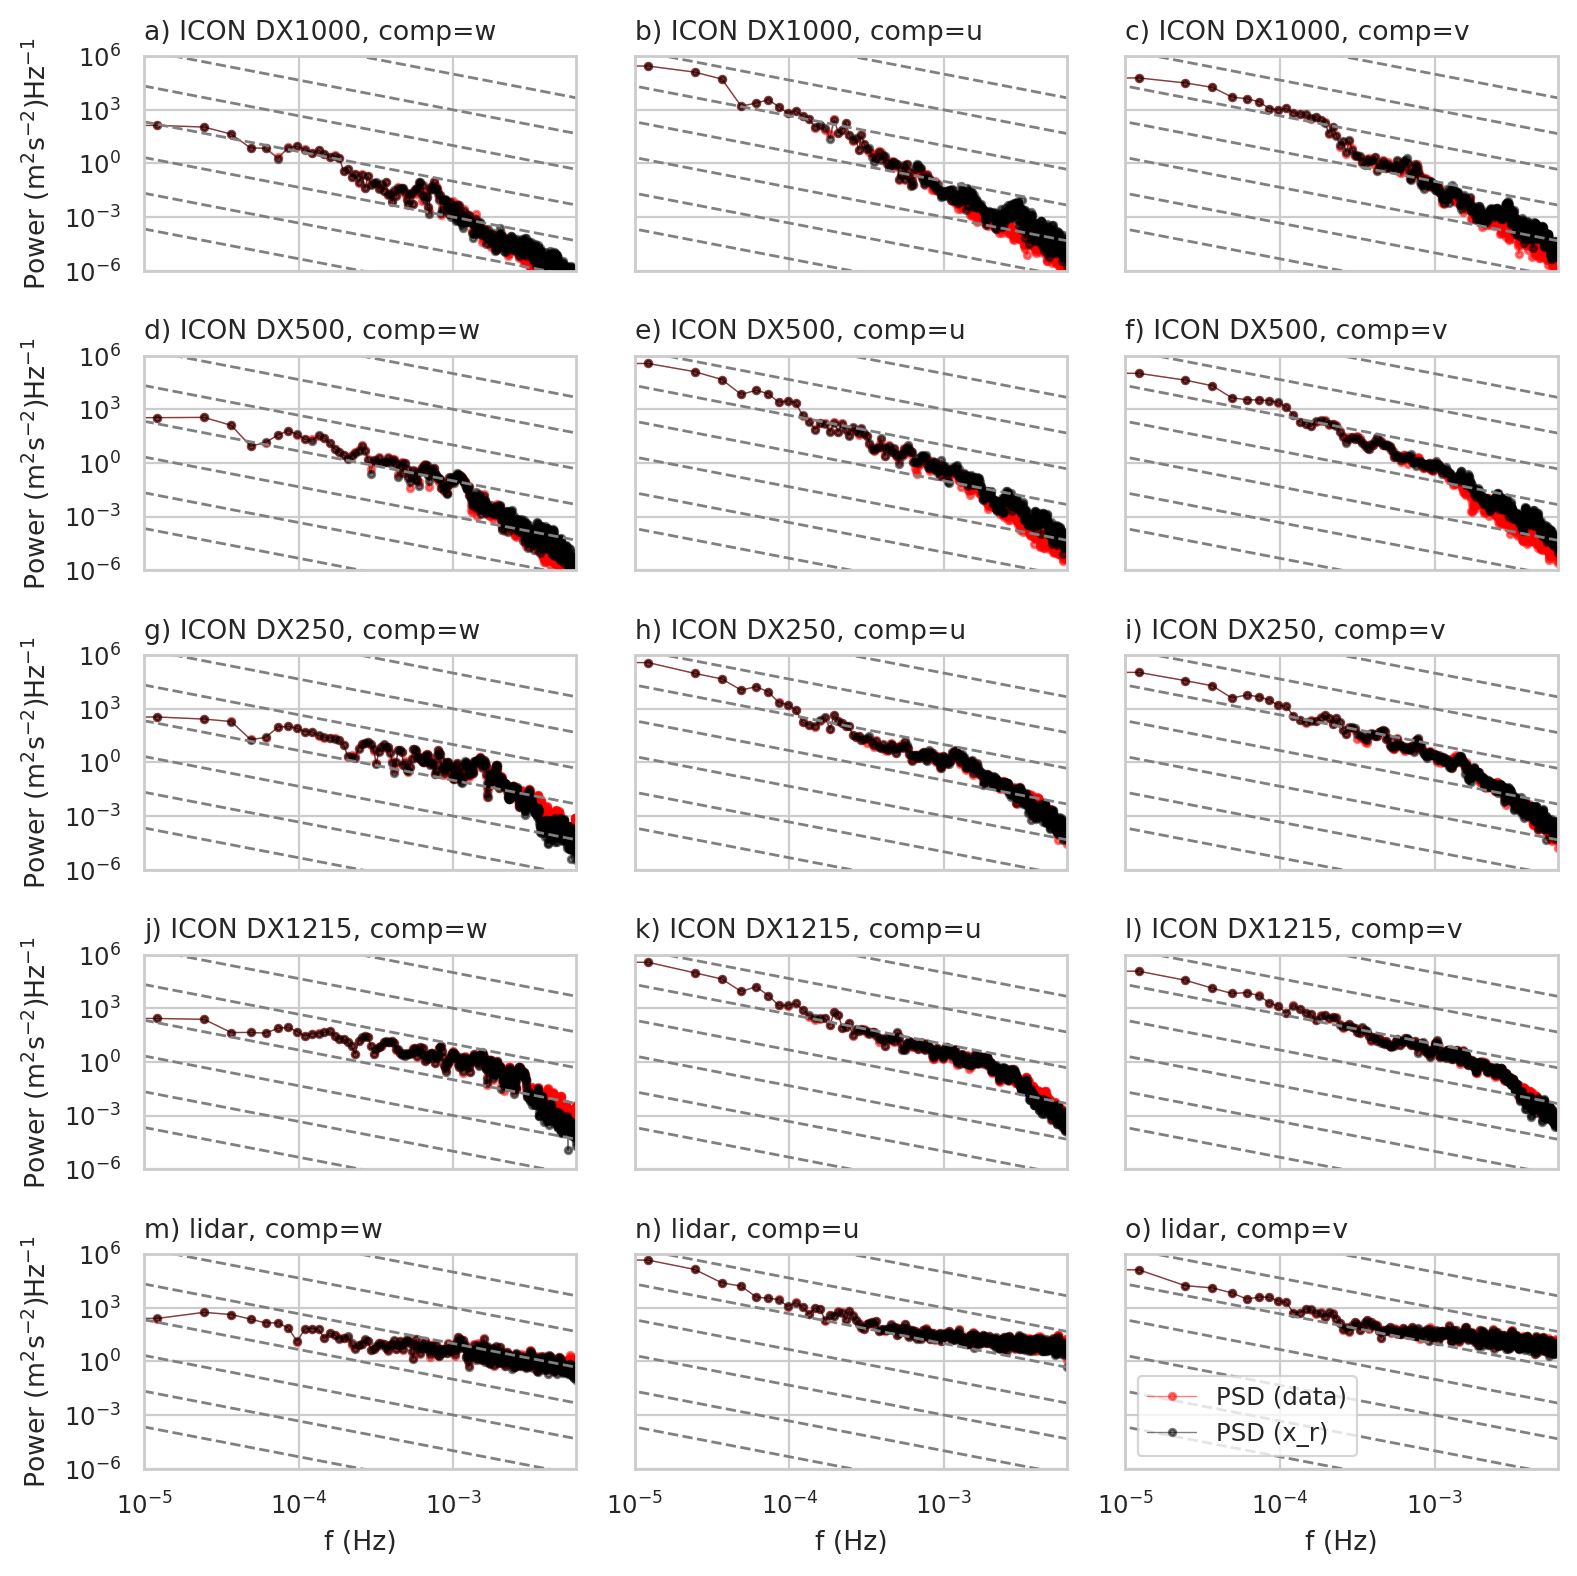

In [13]:
fig, axes = plt.subplots(5, 3, figsize=(8, 4 * 2), sharex=True, sharey=True)
for ndomain, domain in enumerate(domain_list):
    mrc = mrc_dict[domain]
    cluster_centroids, omega_classes, omega_array = mrc.global_cluster_omega(
        n_optimal_dict[domain], transform_method="log10"
    )
    hue_order = np.arange(len(np.unique(omega_classes))).astype(str)
    cluster_centers = (10**cluster_centroids) / (2 * np.pi)

    for ncomp, comp in enumerate(components):
        ax = axes[ndomain, ncomp]
        fs = 1 / np.diff(ts)[0]
        ds_obs = ds_data[domain]
        data = ds_obs[comp].T.values
        # data = np.concatenate(
        #     (ds_obs["w"].T.values, ds_obs["u"].T.values, ds_obs["v"].T.values)
        # )
        f, Pxx_den = signal.welch(data, fs, nperseg=1024, average="median")
        ax.loglog(
            f,
            np.median(Pxx_den, axis=0),
            color="r",
            lw=0.5,
            marker=".",
            alpha=0.5,
            label="PSD (data)",
        )

        xr_global = xr_global_dict[domain][comp]
        f, Pxx_den = signal.welch(xr_global, fs, nperseg=1024, average="median")
        ax.loglog(
            f,
            np.median(Pxx_den, axis=0),
            color="k",
            lw=0.5,
            marker=".",
            alpha=0.5,
            label="PSD (x_r)",
        )
        if ncomp == 0:
            ax.set_ylabel("Power (m$^2$s$^{-2}$)Hz$^{-1}$")
        if not domain == "lidar":
            title = (
                f"{alphabet[ncomp + ndomain * 3]}) ICON {domain_titles_dict[domain]}, comp={comp}"
            )
        else:
            title = f"{alphabet[ncomp + ndomain * 3]}) {domain}, comp={comp}"
            ax.set_xlabel("f (Hz)")
        ax.set_title(title, loc="left")

        # Add slope guides
        for n in np.arange(-2, 12, 0.5):
            if n // 2 == n / 2:
                plot_kwargs = {
                    "color": "0.5",
                    "ls": "--",
                    "lw": 1,
                }
            else:
                continue
            x = np.array([10**-6, 10**-1])
            delta_y = -5 / 3 * (np.log10(x[1]) - np.log10(x[0]))
            y1 = 10**n
            y2 = 10 ** (np.log10(y1) + delta_y)
            ax.loglog(x, np.array([y1, y2]), **plot_kwargs)

ax.legend()
ax.set_ylim(10**-6, 10**6)
ax.set_xlim(10**-5, f.max())

plt.tight_layout()
os.chdir(dir_print)
fig.savefig("fit-eval-spectra.png", dpi=300, bbox_inches="tight")
fig.savefig("fit-eval-spectra.jpg", dpi=300, bbox_inches="tight")
fig.savefig("fit-eval-spectra.pdf", dpi=300, bbox_inches="tight")